In [24]:
import sqlite3
import pandas as pd
import struct
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt

### Vectorización de audio features

In [25]:
def load_data():
    """ Lee features de la base de datos features.db"""

    features_db_path = "dataset/features.db"
    genres_db_path = "dataset/genres.db"
    metadata_db_path = "dataset/metadata.db"
    tags_db_path = "dataset/tags.db"

    conn = sqlite3.connect(features_db_path)
    features_df = pd.read_sql_query("SELECT * FROM features", conn)
    conn.close()

    conn = sqlite3.connect(genres_db_path)
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()

    conn = sqlite3.connect(metadata_db_path)
    metadata_df = pd.read_sql_query("SELECT * FROM metadata", conn)
    conn.close()

    conn = sqlite3.connect(tags_db_path)
    tags_df = pd.read_sql_query("SELECT * FROM tags", conn)
    conn.close()

    return features_df, genres_df, metadata_df, tags_df

features_df, genres_df, metadata_df, tags_df = load_data()

In [26]:
def decode_tempo(b):
    try:
        if isinstance(b, float):
            return b
        if isinstance(b, (bytes, bytearray)) and len(b) == 4:
            return struct.unpack('f', b)[0]  # <-- 'f' = float32 (4 bytes)
        if isinstance(b, str) and ',' in b:
            byte_list = list(map(int, b.split(',')))
            b = bytes(byte_list)
            return struct.unpack('f', b)[0]
    except Exception as e:
        print(f"⚠️ decode_tempo falló con {repr(b)}: {e}")
    return np.nan

def decode_array(b):
    try: 
        return np.frombuffer(b, dtype=np.float32)
    except Exception:
        return b

def concat_full_vector():
    """Concatena en un solo vector datos de features, genres y tags"""
    df = pd.concat([features_df, genres_df, tags_df], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True)
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        row_copy = row.drop(labels=['mfcc_mean', 'tempo', 'stft_mean', 'chroma_mean'], errors = "ignore").copy()
        other_features = row_copy.values.astype(np.float32)
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo, other_features])
        vectors.append(full_vector)
    return np.stack(vectors)

def concat_vector():
    """"Concatena en un solo vector datos de features solo"""
    df = features_df.copy()
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True) 
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo])
        vectors.append(full_vector)
    return np.stack(vectors)

vectors = concat_vector()
full_vectors = concat_full_vector()
print(vectors.shape)
print(vectors[0].shape)
print(full_vectors.shape)
print(full_vectors[0].shape)

(17783, 1051)
(1051,)
(17783, 1146)
(1146,)


### Normalización

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(vectors)
X_full = scaler.fit_transform(full_vectors)

In [28]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_full_train, X_full_test = train_test_split(X_full, test_size=0.2, random_state=42)

### Autoencoders

#### Autoencoder simple (AE)

In [29]:
def build_autoencoder(input_dim, encoding_dim):
    """Construye un autoencoder simple"""
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    decoded = Dense(512, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder, encoder

In [30]:
autoencoder, encoder = build_autoencoder(input_dim=X.shape[1], encoding_dim=128)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test) )
#autoencoder.save("autoencoder.keras")
#encoder.save("encoder.keras")

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.6464 - val_loss: 0.3925
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3781 - val_loss: 0.3119
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3019 - val_loss: 0.2664
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2695 - val_loss: 0.2416
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2414 - val_loss: 0.2280
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2208 - val_loss: 0.2112
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1941 - val_loss: 0.1992
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1712 - val_loss: 0.1859
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1659 - val_loss: 0.1928
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1646 - val_loss: 0.1693
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1468 - val_loss: 0.1608
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1405 - val_

In [31]:
autoencoder_full, encoder_full = build_autoencoder(input_dim=X_full.shape[1], encoding_dim=128)
autoencoder_full.fit(X_full_train, X_full_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_full_test, X_full_test) )
#autoencoder_full.save("autoencoder_full.keras")
#encoder_full.save("encoder_full.keras")

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6886 - val_loss: 0.4441
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4363 - val_loss: 0.3677
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3570 - val_loss: 0.3294
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3094 - val_loss: 0.2959
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2801 - val_loss: 0.2766
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2572 - val_loss: 0.2680
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2454 - val_loss: 0.2522
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2304 - val_loss: 0.2447
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2132 - val_loss: 0.2372
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2086 - val_loss: 0.2239
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1940 - val_loss: 0.2176
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1829 - va

In [32]:
# Evaluación de los autoencoders
decoded_vectors = autoencoder.predict(X_test)
decoded_full_vectors = autoencoder_full.predict(X_full_test)
# MSE
mse_vectors = np.mean(np.power(X_test - decoded_vectors, 2), axis=1)
mse_full_vectors = np.mean(np.power(X_full_test - decoded_full_vectors, 2), axis=1)
# MAE
mae_vectors = np.mean(np.abs(X_test - decoded_vectors), axis=1)
mae_full_vectors = np.mean(np.abs(X_full_test - decoded_full_vectors), axis=1)
# RMSE
rmse_vectors = np.sqrt(mse_vectors)
rmse_full_vectors = np.sqrt(mse_full_vectors)
print(f"MSE: {mse_vectors.mean()} ± {mse_vectors.std()}")
print(f"RMSE: {rmse_vectors.mean()} ± {rmse_vectors.std()}")
print(f"MAE: {mae_vectors.mean()} ± {mae_vectors.std()} \n")

print(f"MSE full: {mse_full_vectors.mean()} ± {mse_full_vectors.std()}")
print(f"RMSE full: {rmse_full_vectors.mean()} ± {rmse_full_vectors.std()}")
print(f"MAE full: {mae_full_vectors.mean()} ± {mae_full_vectors.std()}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 0.10080466419458389 ± 0.4766418933868408
RMSE: 0.2279547154903412 ± 0.22100073099136353
MAE: 0.15222258865833282 ± 0.14222216606140137 

MSE full: 0.13506965339183807 ± 0.6399583220481873
RMSE full: 0.28162503242492676 ± 0.23612919449806213
MAE full: 0.17934054136276245 ± 0.15260320901870728


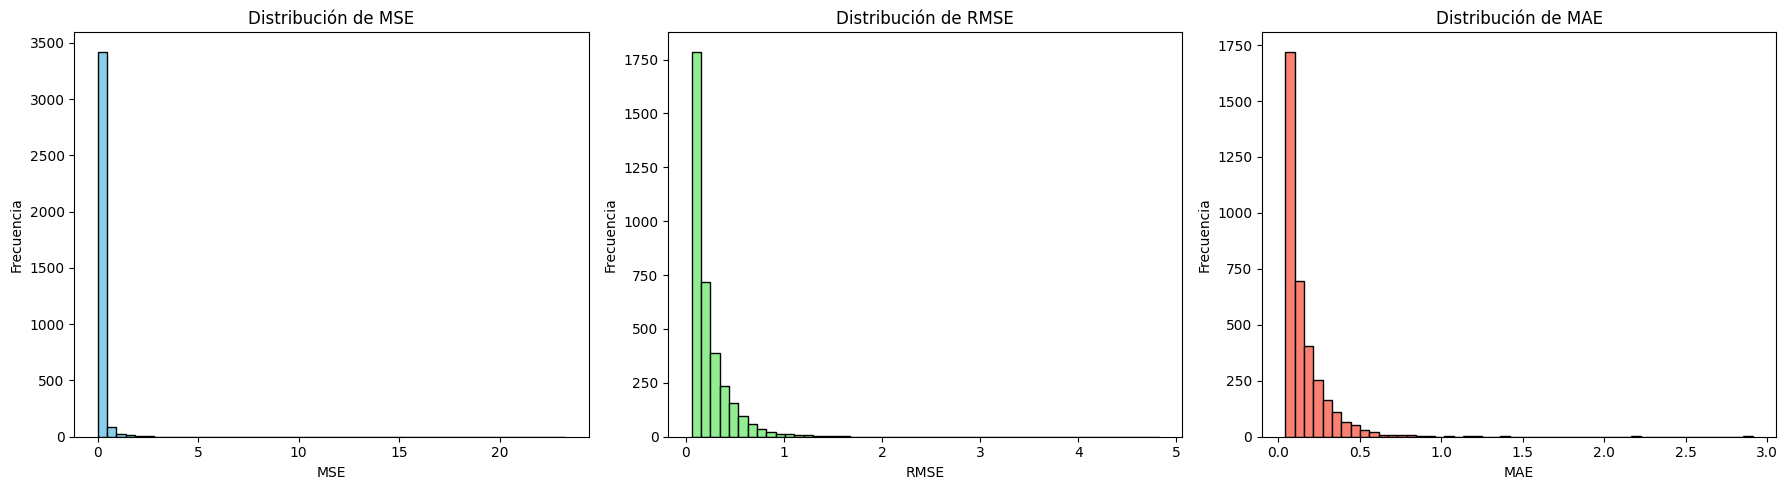

In [33]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(mse_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

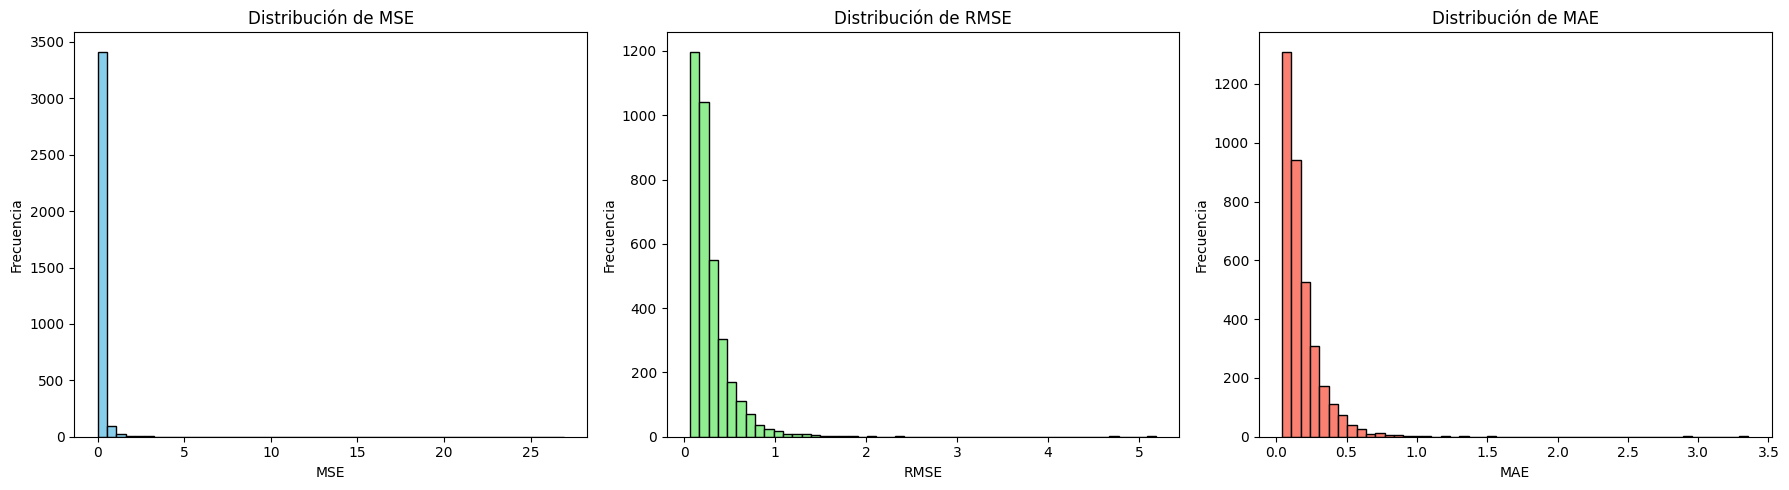

In [34]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(mse_full_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_full_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_full_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Se puede observar que para las tres distribuciones (MSE, RMSE, MAE), la mayoría de muestras tienen errores bajos, y solamente unas pocas tienen errores altos, lo que nos indica que son posibles outliers o ejemplos difíciles de reconstruir.

🟦 Distribución por MSE:
- Se ve un pico pronunciado cerca del 0, es decir, la mayoría de entradas se han reconstruído correctamente
- Tenemos unos cuantos ejemplos con MSE > 1 y algunos extremos que podrían ser anomalías o errores en la reconstrucción

🟩 Distribución de RMSE:
- Muy parecida al MSE
- La mayoría está por debajo de 0.5, lo que es un buen signo

🟥 Distribución de MAE:
- La mayoría de errores son bajos (0 - 0.2)
- Es menos sensible a errores extremos, pero también hay algunos ejemplos con MAE > 2

In [35]:
umbral_rmse = 1.0
outliers = np.where(rmse_vectors > umbral_rmse)[0]
print(f'{len(outliers)} muestras con RMSE > {umbral_rmse}')

42 muestras con RMSE > 1.0


#### Variational Autoencoder (VAE)

Entrenamos finalmente nuestro autencoder con todo el dataset.

In [36]:
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True)
encoded_vectors = encoder.predict(X)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0787
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1262
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1220
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1345
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1407
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1216
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0995
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1031
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0867
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0786
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0746
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0730
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0721
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0690
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0747
Epoch 16/50
70/70 ━

In [37]:
autoencoder_full.fit(X_full, X_full, epochs=50, batch_size=256, shuffle=True)
encoded_full_vectors = encoder_full.predict(X_full)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1104
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1094
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1422
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1175
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1755
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1147
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1315
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1313
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1379
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1216
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1125
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1012
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1048
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1012
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0993
Epoch 16/50
70/70 ━

In [ ]:
df_embeddings = pd.DataFrame({
    'clip_id': features_df['clip_id'].values,
    'original_embeddings': list(vectors),
    'encoded_embeddings': list(encoded_vectors),
    'original_full_embeddings': list(full_vectors),
    'encoded_full_embeddings': list(encoded_full_vectors)
})
df_embeddings.to_sql('embeddings', sqlite3.connect('dataset/embeddings.db'), if_exists='replace', index=False)

clip_ids: 17783
original_embeddings: 17783
encoded_embeddings: 17783
original_full_embeddings: 17783
encoded_full_embeddings: 17783


17783